In [10]:
from datetime import datetime
import numpy as np
import torch
import argparse
import torch.optim as optim
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
sys.path.append("../../")
from TCN.soil_classification.model import TCN
from TCN.soil_classification.utils import data_generator, data_generator_test
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn import metrics

### Value Indexing

In [11]:
LIN_ACC_X = 1
LIN_ACC_Y = 2
LIN_ACC_Z = 3
ANG_VEL_X = 4
ANG_VEL_Y = 5
ANG_VEL_Z = 6
ORIENT_X = 7
ORIENT_Y = 8
ORIENT_Z = 9
ORIENT_W = 10
POS_X = 11
POS_Z = 12
ANG = 13
BOOM = 14
DIPPER = 15
TELE = 16
PITCH = 17

In [12]:
train_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/train"
test_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/test"
X_train, Y_train = data_generator(train_folder, 100, 99, None)
X_test, Y_test, plotting, files = data_generator_test(test_folder, 100, 99, None)

In [13]:
mins, _ = torch.min(torch.min(X_train,1)[0],0)
maxs, _ = torch.max(torch.max(X_train,1)[0],0)
X_train = (X_train-mins)/(maxs-mins)
for traj_idx in range(len(X_test)):
    X_test[traj_idx] = (X_test[traj_idx]-mins)/(maxs-mins)
    X_test[traj_idx] = X_test[traj_idx].permute(0,2,1)
X_train = X_train.permute(0,2,1)
print(X_test[0].shape)
print(X_train.shape)

torch.Size([1504, 17, 100])
torch.Size([54124, 17, 100])


8


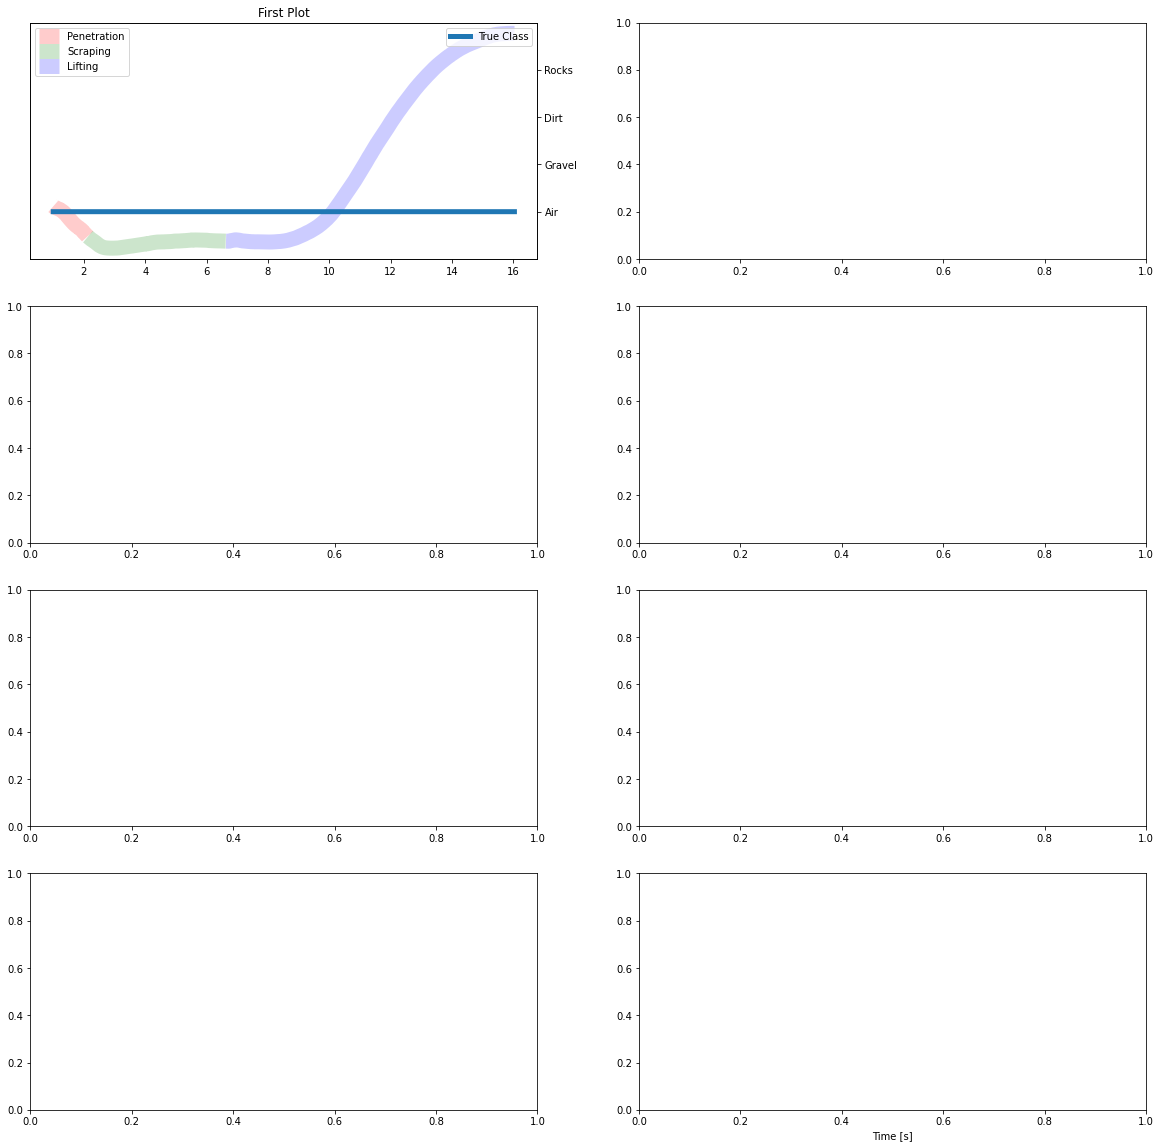

In [87]:
print(len(plotting))
fig, ax1 = plt.subplots(4,2,figsize = [20,20])
ax2 = np.empty_like(ax1)
plt.xlabel("Time [s]")
ax1[0,0].title.set_text('First Plot')
ax2[0,0] = ax1[0,0].twinx() 
colors = ["r","g","b"]
my_xticks = ['Air','Gravel','Dirt','Rocks']
phases = ["Penetration", "Scraping", "Lifting"]
y = np.array([0,1,2,3])
for phase in np.unique(plotting[3][:,-1]):
    ax1[0,0].plot(plotting[3][plotting[3][:,-1]==phase,0],plotting[3][plotting[3][:,-1]==phase,2],color=colors[int(phase)-1],
            linewidth=15, alpha=0.2, label = phases[int(phase)-1], solid_capstyle='butt')
ax2[0,0].plot(plotting[3][:,0],Y_test[1], linewidth=5, label="True Class")
ax2[0,0].set_ylim([-1, 4])
plt.yticks(y,my_xticks)
ax1[0,0].axes.get_yaxis().set_ticks([])
ax1[0,0].legend()
ax2[0,0].legend()
plt.show()

In [3]:
seed = 1111
folder = "/home/mads/git/TCN/TCN/soil_classification/data/prelim"
no_air = True

val_mask = range(LIN_ACC_X,ANG_VEL_Z+1,1)

X, Y = data_generator(folder, 100, 50, val_mask=val_mask)

shuffle_seq = np.arange(X.shape[0])
rng = np.random.default_rng(seed)
rng.shuffle(shuffle_seq)
X = X[shuffle_seq,:,:]
Y = Y[shuffle_seq]

X,Y = Variable(torch.from_numpy(X)), Variable(torch.from_numpy(Y))

if no_air:
    remove_air = Y>0
    X, Y = X[remove_air], Y[remove_air]

input_channels = len(val_mask)
n_classes = 3
batch_size = 32
seq_length = 500
epochs = 10
nhid = 30
levels = 8
ksize = 7

channel_sizes = [nhid]*levels
kernel_size = ksize
dropout = 0.0
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

lr = 4e-3
optimizer = getattr(optim, 'Adam')(model.parameters(), lr=lr)

test_pct = 15

X_train, X_test = X[int(X.size()[0]/100*test_pct):], X[:int(X.size()[0]/100*test_pct)]
Y_train, Y_test = Y[int(X.size()[0]/100*test_pct):], Y[:int(X.size()[0]/100*test_pct)]

In [4]:
mins, _ = torch.min(torch.min(X_train,1)[0],0)
maxs, _ = torch.max(torch.max(X_train,1)[0],0)
X_train, X_test = (X_train-mins)/(maxs-mins), (X_test-mins)/(maxs-mins)
X_train, X_test = X_train.permute(0,2,1), X_test.permute(0,2,1)

In [5]:
X_train.size()

torch.Size([806, 6, 100])

In [6]:
def train(epoch):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    full_loss = 0
    idx = np.arange(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        rng.shuffle(idx)
        if i + batch_size > X_train.size(0):
            x, y = X_train[idx[i:]], Y_train[idx[i:]]
        else:
            x, y = X_train[idx[i:(i+batch_size)]], Y_train[idx[i:(i+batch_size)]]
        optimizer.zero_grad()
        output = model(x)
        loss = F.nll_loss(output, y)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()
        full_loss += loss.item()

        if batch_idx % log_interval == 0:
            cur_loss = total_loss / log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0
    full_loss = full_loss/batch_idx
    return full_loss
            
def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.nll_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()

In [7]:
clip  = -1
log_interval = 25
train_loss = []
test_loss = []
for ep in range(1, epochs+1):
    train_loss.append(train(ep))
    test_loss.append(evaluate())
FORMAT = '%Y-%m-%-d_%H%M%S'
stamp = datetime.now().strftime(FORMAT)
with open('log/train_test_'+stamp+'.csv', 'w') as f:
    f.write(f"epoch, train_loss, test_loss\n")
    for ep,(train, test) in enumerate(zip(train_loss, test_loss)):
        f.write(f"{ep},{train}, {test}\n")

Train Epoch:  1 [   768/   806 (95%)]	Learning rate: 0.0040	Loss: 0.696322

Test set: Average loss: 0.655909

Train Epoch:  2 [   768/   806 (95%)]	Learning rate: 0.0040	Loss: 0.460840

Test set: Average loss: 0.356722

Train Epoch:  3 [   768/   806 (95%)]	Learning rate: 0.0040	Loss: 0.203853

Test set: Average loss: 0.163541

Train Epoch:  4 [   768/   806 (95%)]	Learning rate: 0.0040	Loss: 0.054207

Test set: Average loss: 0.105159

Train Epoch:  5 [   768/   806 (95%)]	Learning rate: 0.0040	Loss: 0.050365

Test set: Average loss: 0.045028

Train Epoch:  6 [   768/   806 (95%)]	Learning rate: 0.0040	Loss: 0.025937

Test set: Average loss: 0.056419

Train Epoch:  7 [   768/   806 (95%)]	Learning rate: 0.0040	Loss: 0.087632

Test set: Average loss: 0.058140

Train Epoch:  8 [   768/   806 (95%)]	Learning rate: 0.0040	Loss: 0.026338

Test set: Average loss: 0.057410

Train Epoch:  9 [   768/   806 (95%)]	Learning rate: 0.0040	Loss: 0.099749

Test set: Average loss: 0.046719

Train Epoc

In [ ]:
N=100
X_num = torch.rand([N, 1, seq_length])
X_mask = torch.zeros([N, 1, seq_length])
Y = torch.zeros([N, 1])
for i in range(N):
    positions = np.random.choice(seq_length, size=2, replace=False)
    X_mask[i, 0, positions[0]] = 1
    X_mask[i, 0, positions[1]] = 1
    Y[i,0] = X_num[i, 0, positions[0]] + X_num[i, 0, positions[1]]
X = torch.cat((X_num, X_mask), dim=1)
add_X, add_Y = Variable(X), Variable(Y)

In [ ]:
add_X.type()

In [ ]:
model.eval()
with torch.no_grad():
    output = model(X_train)

In [ ]:
pred = np.argmax(output.numpy(),axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, pred)

In [8]:
model.eval()
with torch.no_grad():
    output = model(X_train)
pred = np.argmax(output.numpy(),axis=1)
confusion_matrix(Y_train, pred)

array([[368,   4],
       [  0, 434]])

In [9]:
model.eval()
with torch.no_grad():
    output = model(X_test)
pred = np.argmax(output.numpy(),axis=1)
confusion_matrix(Y_test, pred)

array([[64,  3],
       [ 0, 75]])

In [43]:
report = metrics.classification_report(Y_test, pred, output_dict = True)
print(report)

{'1': {'precision': 1.0, 'recall': 0.9552238805970149, 'f1-score': 0.9770992366412213, 'support': 67}, '2': {'precision': 0.9615384615384616, 'recall': 1.0, 'f1-score': 0.9803921568627451, 'support': 75}, 'accuracy': 0.9788732394366197, 'macro avg': {'precision': 0.9807692307692308, 'recall': 0.9776119402985075, 'f1-score': 0.9787456967519832, 'support': 142}, 'weighted avg': {'precision': 0.9796858071505958, 'recall': 0.9788732394366197, 'f1-score': 0.9788384550680824, 'support': 142}}


In [10]:
X_test

tensor([[[0.6322, 0.6322, 0.6322,  ..., 0.6364, 0.6364, 0.6405],
         [0.3216, 0.3216, 0.3222,  ..., 0.3271, 0.3271, 0.3271],
         [0.9244, 0.9239, 0.9239,  ..., 0.9371, 0.9367, 0.9367],
         [0.3011, 0.3011, 0.3008,  ..., 0.3253, 0.3253, 0.3251],
         [0.4425, 0.4425, 0.4454,  ..., 0.4483, 0.4483, 0.4536],
         [0.5868, 0.5868, 0.5900,  ..., 0.5835, 0.5835, 0.5892]],

        [[0.6983, 0.6901, 0.6860,  ..., 0.7893, 0.7851, 0.7893],
         [0.4040, 0.4047, 0.4047,  ..., 0.3645, 0.3631, 0.3631],
         [0.5614, 0.5619, 0.5629,  ..., 0.5836, 0.5841, 0.5841],
         [0.5990, 0.5992, 0.5996,  ..., 0.5754, 0.5754, 0.5745],
         [0.4991, 0.4980, 0.4974,  ..., 0.5108, 0.5108, 0.5096],
         [0.6247, 0.6239, 0.6239,  ..., 0.6941, 0.6941, 0.6933]],

        [[0.4380, 0.4380, 0.4339,  ..., 0.4669, 0.4587, 0.4545],
         [0.7477, 0.7457, 0.7464,  ..., 0.7346, 0.7387, 0.7422],
         [0.4022, 0.4060, 0.4083,  ..., 0.3634, 0.3634, 0.3625],
         [0.2144, 0.2

In [33]:
Y_train

tensor([1, 1, 2, 1, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1,
        2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0, 2, 2, 0, 2, 1, 2, 2, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 0, 2, 2, 0, 1, 2, 2, 2,
        2, 1, 2, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1,
        1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1,
        1, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1,
        2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 1, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        1, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 1, 2,
        2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 2, 2,
        2, 1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 1,

In [34]:
from TCN.soil_classification.utils import data_generator_test

In [18]:
                train_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/train"
                test_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/test"
                X_train, Y_train = data_generator(train_folder, seq_len, overlap, phase =phase, val_mask=val_mask, rng=rng)
                X_test, Y_test, plotting, files = data_generator_test(test_folder, seq_len, overlap, phase=phase, val_mask=val_mask)

In [33]:
l = np.array([np.ones(5),np.ones(5)*2,np.ones(5)*3])
print(l)
l[:,:1] = np.linalg.norm(l[:,:2], axis=1).reshape(3,1)
l = np.delete(l,[1,2], axis=1)
print(l)

[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]]
[[1.41421356 1.         1.        ]
 [2.82842712 2.         2.        ]
 [4.24264069 3.         3.        ]]


In [25]:
np.linalg.norm(l[:,:2], axis=1)

array([1.41421356, 2.82842712, 4.24264069])

In [26]:
np.sqrt(3**2+3**2)

4.242640687119285

In [72]:
X_train[:,:,0] = torch.linalg.norm(X_train[:,:,0:3], dim = 2)
X_train[:,:,1] = torch.linalg.norm(X_train[:,:,3:6], dim = 2)
X_train = X_train[:,:,[0,1]+list(range(6,X_train.shape[2],1))]
print(X_train[0])

tensor([[ 1.0023e+01,  1.2830e-02, -9.7649e-01,  ..., -3.9435e+04,
         -5.9584e+04, -5.2401e+03],
        [ 1.0009e+01,  1.0317e-02, -9.7648e-01,  ..., -4.0132e+04,
         -5.8776e+04, -5.0119e+03],
        [ 9.9963e+00,  1.0038e-02, -9.7647e-01,  ..., -3.9834e+04,
         -5.9984e+04, -5.2399e+03],
        ...,
        [ 1.0456e+01,  5.7011e-02, -9.7892e-01,  ..., -2.6394e+04,
         -5.8711e+04, -7.2483e+03],
        [ 1.0268e+01,  5.7686e-02, -9.7898e-01,  ..., -2.5990e+04,
         -5.8337e+04, -6.6562e+03],
        [ 1.0103e+01,  5.7531e-02, -9.7903e-01,  ..., -2.4461e+04,
         -5.8519e+04, -7.3325e+03]])


In [61]:
[0,1]+list(range(6,X_train.shape[2],1))

[0, 1]

In [62]:
list(range(6,X_train.shape[2],1))

[]

In [74]:
X_test[0].shape

torch.Size([1504, 100, 17])

In [79]:
traj_idx=0
X_test[traj_idx][:,:,0] = torch.linalg.norm(X_test[traj_idx][:,:,0:3], dim = 2)
X_test[traj_idx][:,:,1] = torch.linalg.norm(X_test[traj_idx][:,:,3:6], dim = 2)
X_test[traj_idx] = X_test[traj_idx][:,:,[0,1]+list(range(6,X_test[traj_idx].shape[2],1))]

In [77]:
X_test[traj_idx][:,:,0].shape

torch.Size([1504, 100])

In [94]:
X_train.shape

torch.Size([54124, 100, 17])

In [110]:
mins = torch.min(X_train,1)[0].unsqueeze(1)
maxs = torch.max(X_train,1)[0].unsqueeze(1)

X_train_seq_normed = (X_train-mins)/(maxs-mins)
print(X_train_seq_normed[0,:,0])

tensor([0.5111, 0.5111, 0.4889, 0.5111, 0.5111, 0.5556, 0.5556, 0.5778, 0.6000,
        0.7111, 0.7333, 0.7333, 0.7556, 0.7778, 0.7333, 0.6889, 0.6667, 0.6444,
        0.6222, 0.6222, 0.6000, 0.6222, 0.6222, 0.5778, 0.5778, 0.5556, 0.5333,
        0.4889, 0.4222, 0.4000, 0.3556, 0.3556, 0.2889, 0.2889, 0.2667, 0.2667,
        0.2667, 0.2889, 0.3111, 0.3556, 0.3778, 0.4444, 0.5111, 0.6000, 0.6222,
        0.6667, 0.7111, 0.7556, 0.7556, 0.7333, 0.6889, 0.6889, 0.7111, 0.7111,
        0.6667, 0.7111, 0.6889, 0.6667, 0.6222, 0.6222, 0.6222, 0.6444, 0.6667,
        0.7111, 0.7556, 0.8000, 0.8444, 0.8444, 0.8889, 0.8444, 0.8000, 0.7111,
        0.6222, 0.5111, 0.4222, 0.3111, 0.2889, 0.3111, 0.4222, 0.5333, 0.6667,
        0.7556, 0.8444, 0.9111, 0.9778, 1.0000, 0.9556, 0.9111, 0.7778, 0.6889,
        0.5333, 0.4222, 0.2889, 0.1556, 0.0889, 0.0222, 0.0000, 0.0222, 0.0222,
        0.0889])


In [8]:
print(reversed(range(8)))